D'abord les imports

In [2]:
import numpy as np
import scipy as sp

import pygeomphase as pgp
import bispy as bsp
import quaternion

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

#from tqdm import tqdm

Paramètre du signal


/!\ Super important : si theta est modifier, il faudra aussi modifier theta' !!!

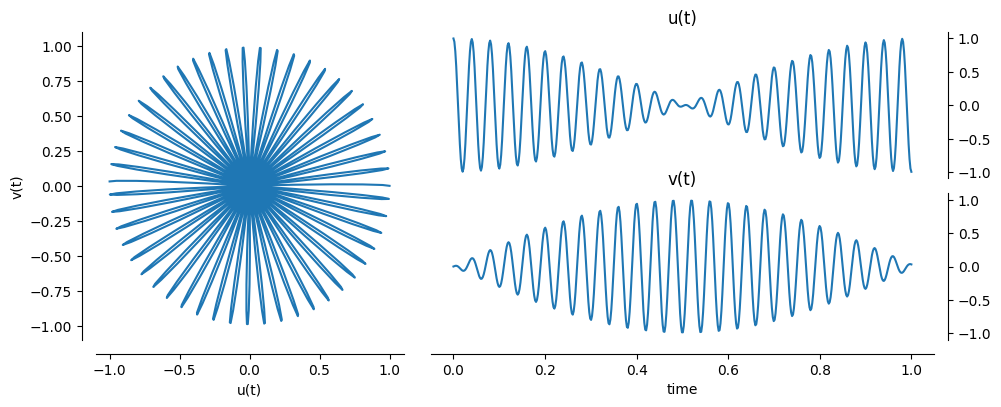

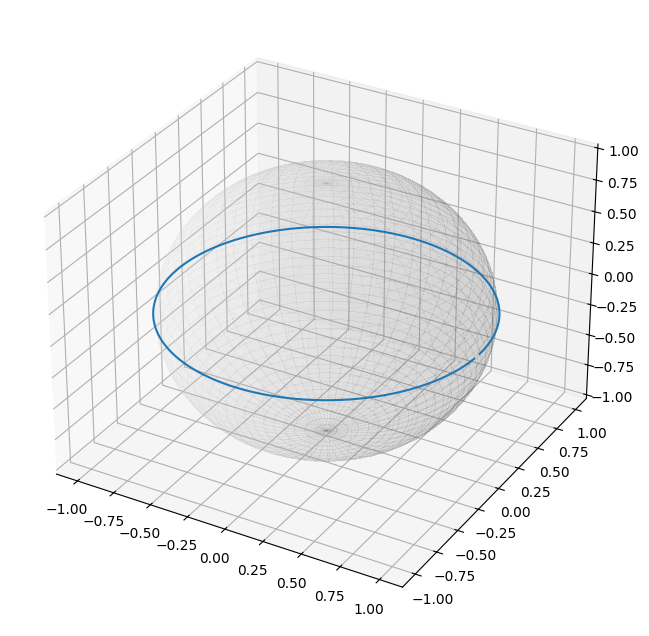

In [3]:
    # Pas de temps

L = 1#5                     # durée du signal
N = 500                     # nombre de mesures par unité de temps
t = np.linspace(0, L, L*N)  # array des temps


    # Paramètres du signal (ampli, phase, ...)

a = np.ones_like(t)

def phi_f(t):
    return 50 * np.pi * t

def theta_f(t):
    return np.pi*0.99  * t

def theta_p(t): #theta prime, ca dérivée en somme
    return np.pi*0.99

def chi_f(t):
    return 0#np.pi/10

# valeurs associées aux fonctions
phi  =  np.array([phi_f(t_) for t_ in t])
theta  =  np.array([theta_f(t_) for t_ in t])
chi  =  np.array([chi_f(t_) for t_ in t])


    # Construction du signal

env = a
#env = bsp.utils.windows.hanning(L*N)

x = bsp.signals.bivariateAMFM(env, theta, chi, phi)

# en fonction des paramètres de Stokes
S0, S1, S2, S3 = bsp.utils.geo2Stokes(a, theta, chi)
#print(f'{x = }\n')

# comme vecteur complexe
x1, x2 = bsp.utils.sympSplit(x)
xvec = np.array([x1, x2])


    # Plots

# en 2D

bsp.utils.visual.plot2D(t, x)
plt.show() 


# en 3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d", computed_zorder=False)

# ajout de la sphère
u, v = np.mgrid[0 : 2 * np.pi : 50j, 0 : np.pi : 50j]
r1 = np.cos(u) * np.sin(v)
r2 = np.sin(u) * np.sin(v)
r3 = np.cos(v)

r = 0.99
ls = LightSource(azdeg=210, altdeg=30)
ax.plot_surface(r * r1, r * r2, r * r3, color=(0.9, 0.9, 0.9), alpha=0.1, zorder=-1, rstride=1, cstride=1, linewidth=0, antialiased=False)

# plot du signal sur la sphère
ax.plot(S1/S0, S2/S0, S3/S0)
plt.show()

Calcul des la phases géométrique avec différentes formules

In [ ]:
    # Calcul façon Bargmann (normalisé ou non)

# la "vraie" phase g
phig_b = -np.angle(pgp.bargmann_invariant(xvec))
phig_b2 = -np.angle(pgp.bargmann_invariants(xvec))

#print(f'\n{phig_b =} \n{phig_b2 =} \n {xvec.shape = }\n')


phig_arg[i] = np.float64(0.0) 	 phig_tan[i] = np.float64(0.0) 	 phig_b[i] = np.float64(-0.0)
phig_arg[i] = np.float64(0.0) 	 phig_tan[i] = np.float64(0.0) 	 phig_b[i] = np.float64(-7.492239419526065e-17)
phig_arg[i] = np.float64(0.0) 	 phig_tan[i] = np.float64(0.0) 	 phig_b[i] = np.float64(-6.96600057706006e-17)
phig_arg[i] = np.float64(3.141592653589793) 	 phig_tan[i] = np.float64(-0.0) 	 phig_b[i] = np.float64(3.141592653589793)
phig_arg[i] = np.float64(3.141592653589793) 	 phig_tan[i] = np.float64(-0.0) 	 phig_b[i] = np.float64(3.141592653589793)


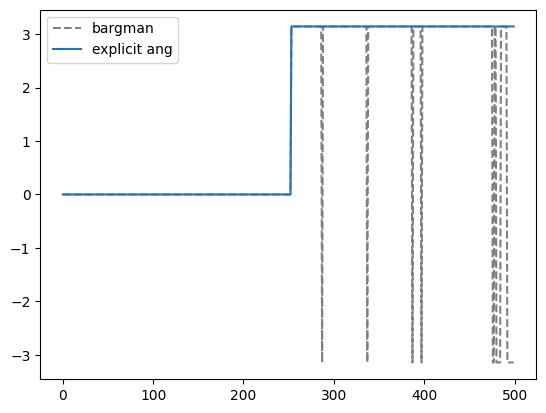

In [ ]:
    # Avec la formule du stagière

# calcul le terme dans la phase totale   
def terme_entro(i, theta, chi, arg=True):
    Dtheta = theta[i]-theta[0]
    Dchi = chi[i]-chi[0]
    Schi = chi[i]+chi[0]

    # version (arg)1
    if arg :
        bb = np.cos(Dtheta) * np.cos(Dchi) + 1j * (np.sin(Dtheta) * np.sin(Schi))
        return np.angle(bb)
    # version (atan)2
    else :
        num = np.tan(Dtheta) * (np.tan(chi[i]) + np.tan(chi[0]))
        den = 1 + np.tan(chi[i])*np.tan(chi[0])
        return np.atan2(num, den)

# calcul itératif de la phase géométrique
phig_arg = np.empty_like(t)
phig_tan = np.empty_like(t)

plus1 = np.empty_like(t)
plus2 = np.empty_like(t)

for i,t_ in enumerate(t) :
    # terme intégrale dans la phase dynamique
    phig_arg[i] = -sp.integrate.quad(lambda s: (theta_p(s) * np.sin(2*chi_f(s))), t[0], t_)[0]
    phig_tan[i] = phig_arg[i]
    # et du terme en arctan dans la phase total
    plus1[i] = terme_entro(i, theta, chi, arg=True)
    plus2[i] = terme_entro(i, theta, chi, arg=False)

    phig_arg[i] += plus1[i]
    phig_tan[i] += plus2[i]

    if i%100 == 0:
        print(f'{phig_arg[i] = } \t {phig_tan[i] = } \t {phig_b[i] = }')
    # Plot des 3

#print(f'{phig1=}')
#print(f'{phig2=}')
#print(f'{phig_formule=}')

plt.plot(np.unwrap(phig_b), label='bargman', color='gray', ls='--')
plt.plot(np.unwrap(phig_b) - np.pi, color='gray', ls='--')
plt.plot(np.unwrap(phig_b) - 2*np.pi, color='gray', ls='--')
#plt.plot(phig_b, label='bargmann unnmz')

plt.plot(phig_arg, label='explicit ang')     # np.unwrap(phig_arg, np.pi)
plt.plot(phig_tan, label='explicit atan2')     # np.unwrap(phig_formule, np.pi)
plt.legend()
plt.show()




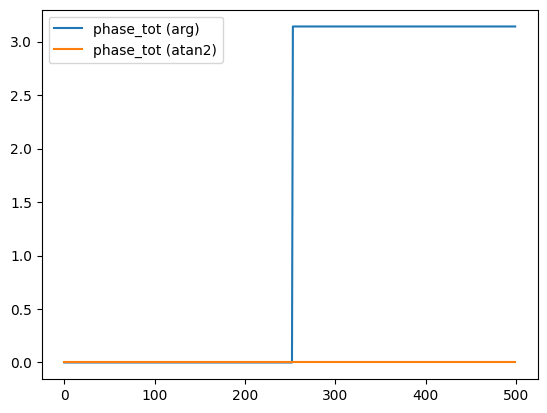

In [6]:
plt.plot(plus1, label='phase_tot (arg)')     # np.unwrap(phig_arg, np.pi)
plt.plot(plus2, label='phase_tot (atan2)')     # np.unwrap(phig_formule, np.pi)
plt.legend()
plt.show()